In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_analises_original = pd.read_csv("data/df_analises.csv")
dic = pd.read_csv("data/dic.csv")
#28s

In [ ]:
df_analises_original = df_analises_original[df_analises_original["V0025A"] == 1]
df_analises_original = df_analises_original.copy()
df_analises_original = df_analises_original[df_analises_original["V0025A"] == 1]
fator_ajuste = 94114 / 168426190
df_analises_original["fator_ajuste"] = df_analises_original["V00291"] * fator_ajuste
df_analises_original = df_analises_original.dropna(subset=["fator_ajuste"])
# df_analises_original = df_analises_original[df_analises_original["E01201"].isin([833, 8331, 8332])]
# df_analises_original = df_analises_original[df_analises_original["E01201"].isin([1112])] #LEGISLADORES

In [7]:
df_analises_original.groupby("E01201")["UPA_PNS"].count().reset_index()

,E01201,UPA_PNS
0,1112.0,68


In [8]:
columns =  ["Expectativa_de_Vida", "Estado", "fator_ajuste", "V00291", "P00901", "P018", "P035", "P03201", "N00101"]
df_analises = df_analises_original[columns].copy()
df_analises["P03201"] = df_analises["P03201"].fillna(2)
df_filtered = df_analises

def weighted_mean(group, value_column, weight_column):
    return (group[value_column] * group[weight_column]).sum() / group[weight_column].sum()

# Aplicar a média ponderada para todas as colunas numéricas por estado
df_analises = df_filtered.groupby("Estado").apply(
    lambda group: pd.Series({
        col: weighted_mean(group, col, "fator_ajuste")
        for col in df_filtered.select_dtypes(include="number").columns
        if col not in ["V00291", "fator_ajuste"]  # Excluir pesos e colunas irrelevantes
    })
).reset_index()
numerical_columns = df_analises.select_dtypes(include="number")
correlacoes = numerical_columns.corr()["Expectativa_de_Vida"]

print("\nCorrelação com Expectativa de Vida:")
display(correlacoes)



Correlação com Expectativa de Vida:


/tmp/ipykernel_668434/4265584265.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analises = df_filtered.groupby("Estado").apply(


Expectativa_de_Vida    1.000000
P00901                 0.221492
P018                   0.051636
P035                  -0.033760
P03201                 0.069433
N00101                 0.031026
Name: Expectativa_de_Vida, dtype: float64

In [9]:
import numpy as np
import pandas as pd

columns =  ["Expectativa_de_Vida", "P00901", "P018", "P035", "P03201", "N00101"]

DATA = df_analises[columns]

# Separar as variáveis independentes (X) e dependente (y)
X = DATA.iloc[:, 1:].values  # Matriz de variáveis independentes
y = DATA.iloc[:, 0].values  # Vetor de variável dependente
X_obs = DATA.iloc[0, 1:].values  # Observação específica de X
y_obs = DATA.iloc[0, 0]  # Observação específica de y (para comparação)

# Passo 1: Estimar as médias
mu_X = np.mean(X, axis=0)  # Média de X (vetor)
mu_Y = np.mean(y)  # Média de y (escalar)

# Passo 2: Estimar a matriz de covariância
# Combinar X e y em uma matriz única para calcular a covariância conjunta
data_combined = np.column_stack((X, y))  # Combinação de X e y
cov_matrix = np.cov(data_combined, rowvar=False)  # Matriz de covariância conjunta

# Separar os blocos da matriz de covariância
num_features = X.shape[1]
Sigma_X = cov_matrix[:num_features, :num_features]  # Matriz de covariância de X
Sigma_Y = cov_matrix[num_features:, num_features:]  # Variância de y (escalar)
Sigma_YX = cov_matrix[num_features:, :num_features]  # Covariância entre y e X
Sigma_XY = Sigma_YX.T  # Covariância entre X e y

# Passo 3: Calcular a média condicional
# Fórmula: μ_Y|X = μ_Y + Σ_YX Σ_X⁻¹ (X_obs - μ_X)
Sigma_X_inv = np.linalg.inv(Sigma_X)  # Inversa da matriz de covariância de X
mu_Y_given_X = mu_Y + Sigma_YX @ Sigma_X_inv @ (X_obs - mu_X)

# Passo 4: Calcular a variância condicional
# Fórmula: Var(Y|X) = Σ_Y - Σ_YX Σ_X⁻¹ Σ_XY
var_Y_given_X = Sigma_Y - Sigma_YX @ Sigma_X_inv @ Sigma_XY

# Resultados
print(f"Média condicional de y dado X_obs: {mu_Y_given_X}")
print(f"Variância condicional de y dado X_obs: {var_Y_given_X}")
print(f"Desvio condicional de y dado X_obs: {var_Y_given_X**0.5}")
print(f"Valor observado de y: {y_obs}")
print(f"Erro para 95% de nivel de confiança: {1.96 * var_Y_given_X**0.5} anos" )


Média condicional de y dado X_obs: [74.16373431]
Variância condicional de y dado X_obs: [[4.30621227]]
Desvio condicional de y dado X_obs: [[2.07514151]]
Valor observado de y: 73.0
Erro para 95% de nivel de confiança: [[4.06727735]] anos


In [10]:

conditional_sd = np.sqrt(var_Y_given_X)[0, 0]  # Desvio padrão condicional (escalares)
# Calcula a média condicional (expectativa de vida predita) para cada estado
predicted_y = []
for i in range(X.shape[0]):
    x_obs = X[i, :]
    # Fórmula: μ_Y|X = μ_Y + Σ_YX Σ_X⁻¹ (x_obs - μ_X)
    mu_Y_given_X = mu_Y + Sigma_YX @ Sigma_X_inv @ (x_obs - mu_X)
    predicted_y.append(mu_Y_given_X[0])  # Extraindo o valor escalar

# Adiciona os resultados ao DataFrame
df_analises['Predicted_Expectativa_de_Vida'] = predicted_y
df_analises['Predicted_Expectativa_de_Vida'] = df_analises['Predicted_Expectativa_de_Vida'].round(1)
df_analises['Conditional_SD'] = conditional_sd

# Exibe as colunas com os resultados
df_analises[["Estado", "Expectativa_de_Vida", 'Predicted_Expectativa_de_Vida', 'Conditional_SD']]

,Estado,Expectativa_de_Vida,Predicted_Expectativa_de_Vida,Conditional_SD
0,Acre,73.0,74.2,2.075142
1,Alagoas,71.6,74.6,2.075142
2,Amazonas,73.6,74.5,2.075142
3,Bahia,73.5,74.0,2.075142
4,Ceará,73.1,73.5,2.075142
5,Distrito Federal,77.6,74.8,2.075142
6,Espírito Santo,77.2,73.7,2.075142
7,Goiás,74.8,74.5,2.075142
8,Maranhão,71.7,74.2,2.075142
9,Mato Grosso,74.5,74.2,2.075142


In [11]:

conditional_sd = np.sqrt(var_Y_given_X)[0, 0]  # Desvio padrão condicional (escalares)
# Calcula a média condicional (expectativa de vida predita) para cada estado
predicted_y = []
for i in range(X.shape[0]):
    x_obs = X[i, :]
    # Fórmula: μ_Y|X = μ_Y + Σ_YX Σ_X⁻¹ (x_obs - μ_X)
    mu_Y_given_X = mu_Y + Sigma_YX @ Sigma_X_inv @ (x_obs - mu_X)
    predicted_y.append(mu_Y_given_X[0])  # Extraindo o valor escalar

# Adiciona os resultados ao DataFrame
df_analises['Predicted_Expectativa_de_Vida'] = predicted_y
df_analises['Predicted_Expectativa_de_Vida'] = df_analises['Predicted_Expectativa_de_Vida'].round(1)
df_analises['Conditional_SD'] = conditional_sd

# Exibe as colunas com os resultados
df_analises[["Estado", "Expectativa_de_Vida", 'Predicted_Expectativa_de_Vida', 'Conditional_SD']]

,Estado,Expectativa_de_Vida,Predicted_Expectativa_de_Vida,Conditional_SD
0,Acre,73.0,74.2,2.075142
1,Alagoas,71.6,74.6,2.075142
2,Amazonas,73.6,74.5,2.075142
3,Bahia,73.5,74.0,2.075142
4,Ceará,73.1,73.5,2.075142
5,Distrito Federal,77.6,74.8,2.075142
6,Espírito Santo,77.2,73.7,2.075142
7,Goiás,74.8,74.5,2.075142
8,Maranhão,71.7,74.2,2.075142
9,Mato Grosso,74.5,74.2,2.075142


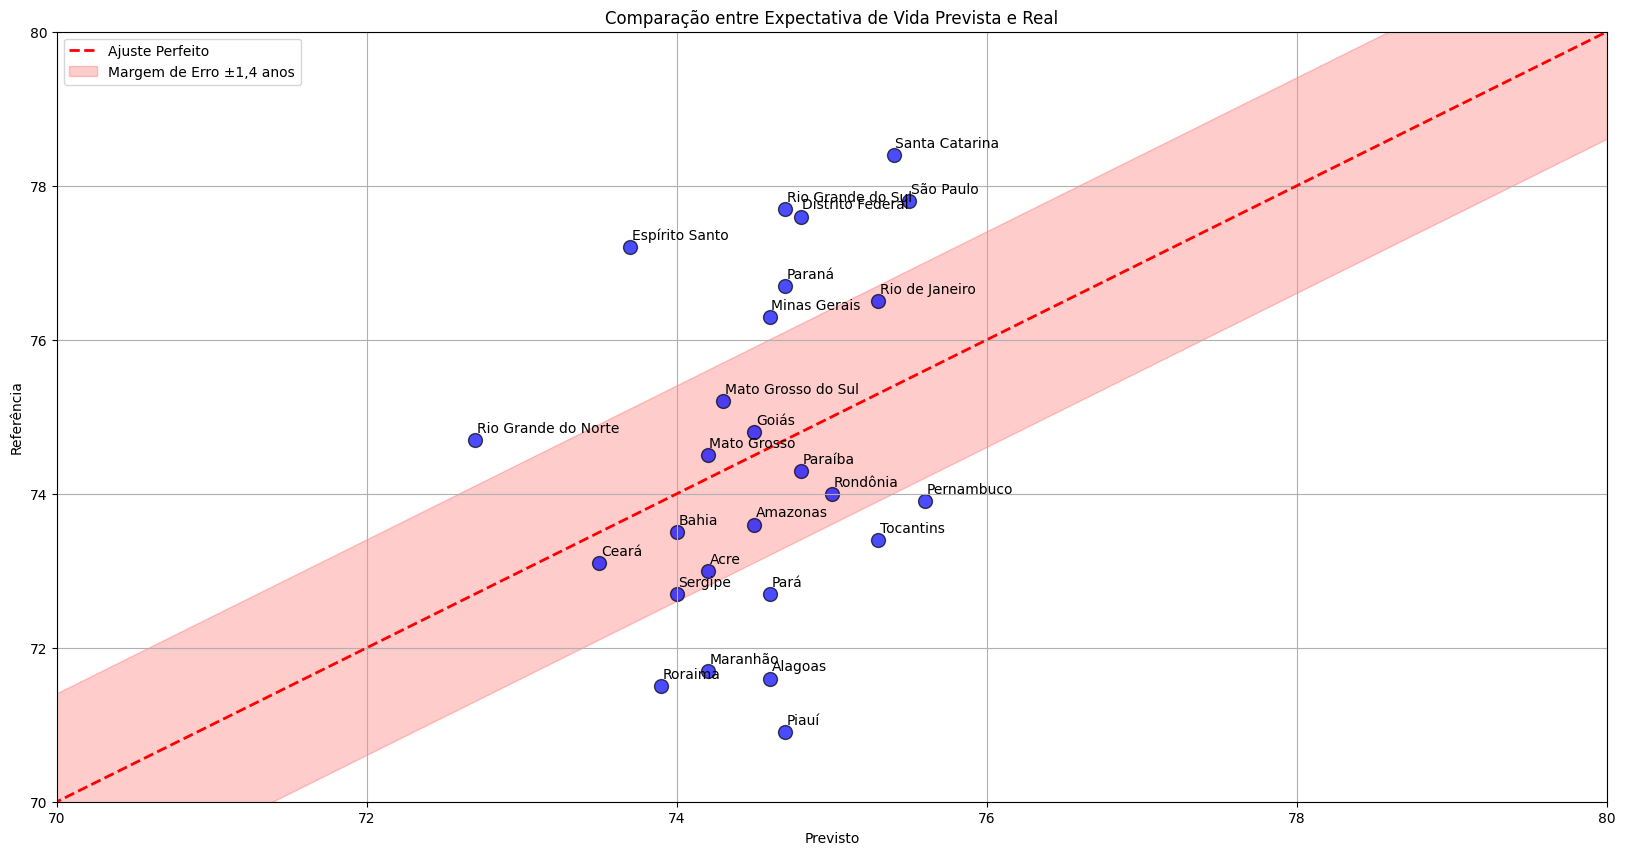

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define o tamanho da figura
plt.figure(figsize=(20, 10))



# Determina os limites mínimos e máximos
min_val = min(df_analises["Predicted_Expectativa_de_Vida"].min(), df_analises["Expectativa_de_Vida"].min())
max_val = max(df_analises["Predicted_Expectativa_de_Vida"].max(), df_analises["Expectativa_de_Vida"].max())

# Cria uma sequência de valores para a linha de referência
x_vals = np.linspace(min_val-5, max_val+5, 100)

# Plota a linha de perfeita correspondência: y = x
plt.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito')

# Adiciona a área sombreada para a margem de erro de ±1,4 anos
plt.fill_between(x_vals, x_vals - 1.4, x_vals + 1.4, color='red', alpha=0.2, label='Margem de Erro ±1,4 anos')
# Cria o scatter plot com x = valores preditos e y = valores reais
plt.scatter(df_analises["Predicted_Expectativa_de_Vida"], 
            df_analises["Expectativa_de_Vida"],
            color='blue', alpha=0.7, edgecolor='k', s=100)
# Adiciona o nome do estado ao lado de cada ponto (supondo que a coluna seja 'Estado')
for i, row in df_analises.iterrows():
    plt.text(row["Predicted_Expectativa_de_Vida"] + 0.01, row["Expectativa_de_Vida"] + 0.1, 
             str(row["Estado"]), fontsize=10)

# Rótulos dos eixos e título
plt.xlabel("Previsto")
plt.ylabel("Referência")
plt.title("Comparação entre Expectativa de Vida Prevista e Real")
plt.xlim([70, 80])

plt.ylim([70, 80])
# Exibe a legenda e a grade
plt.legend()
plt.grid(True)

plt.show()


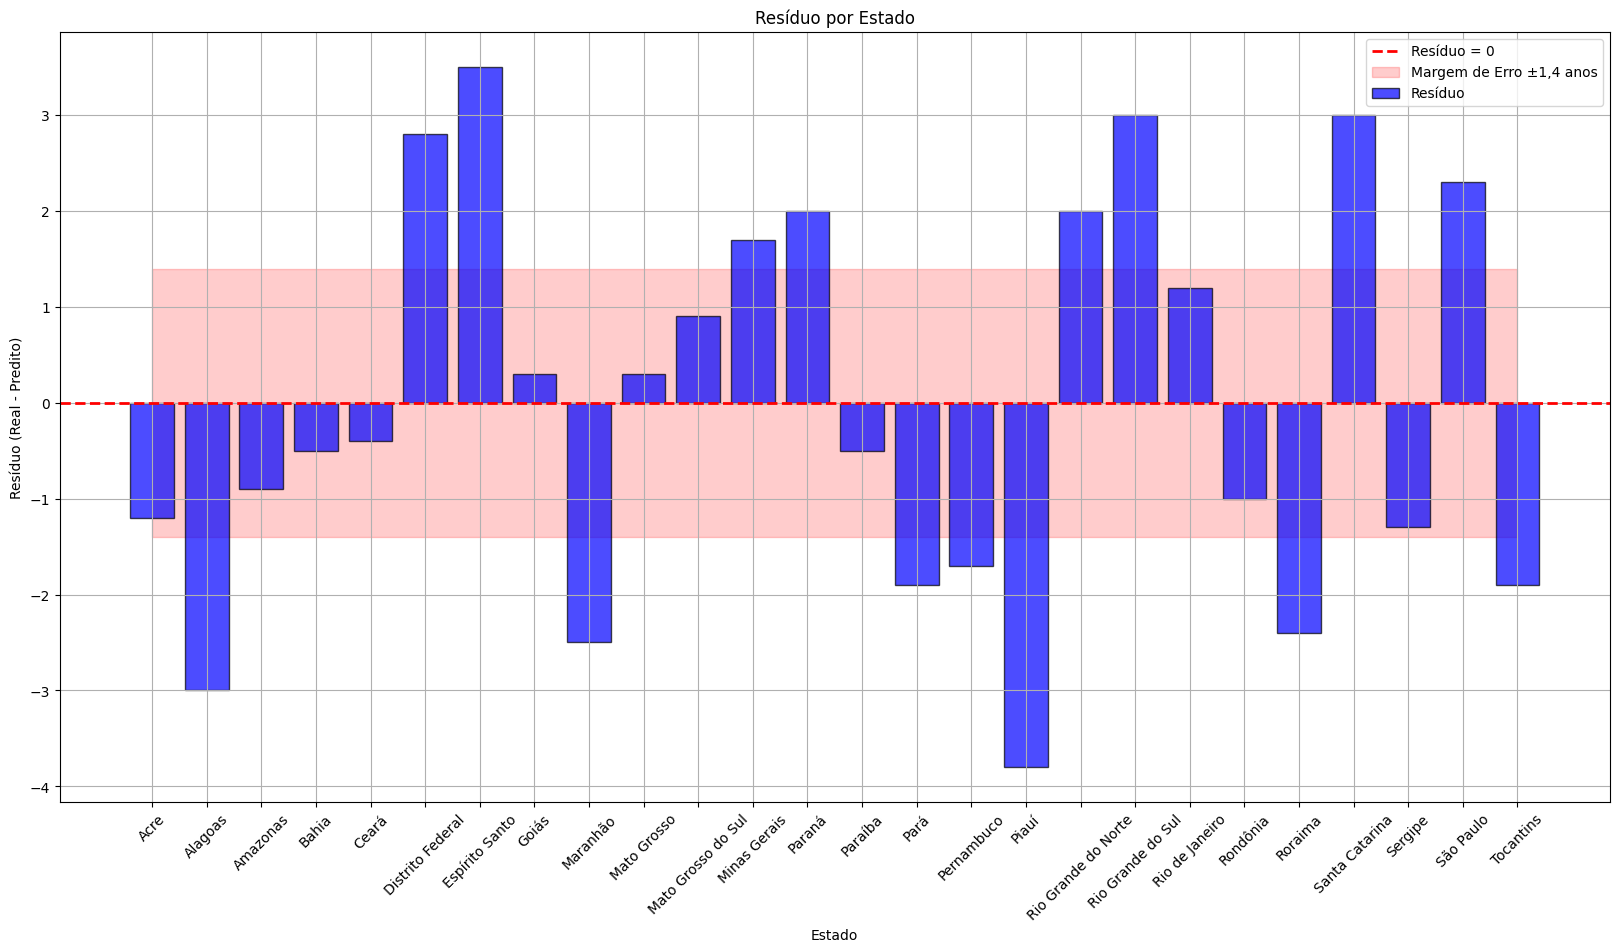

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Calcula os resíduos (valor real - valor predito) para cada estado
df_analises['Residual'] = df_analises['Expectativa_de_Vida'] - df_analises['Predicted_Expectativa_de_Vida']

# Define o tamanho da figura
plt.figure(figsize=(20, 10))


# Adiciona uma linha horizontal em y = 0 para referência
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Resíduo = 0')

# Adiciona área sombreada para a margem de erro de ±1,4 anos em torno de zero
plt.fill_between(x=np.arange(len(df_analises)), y1=-1.4, y2=1.4, color='red', alpha=0.2, label='Margem de Erro ±1,4 anos')
# Cria o gráfico de barras com os estados no eixo x e os resíduos no eixo y
plt.bar(df_analises['Estado'], df_analises['Residual'], color='blue', alpha=0.7, edgecolor='k', label='Resíduo')

# Rótulos dos eixos e título
plt.xlabel("Estado")
plt.ylabel("Resíduo (Real - Predito)")
plt.title("Resíduo por Estado")

# Gira os rótulos do eixo x para melhor visualização, se necessário
plt.xticks(rotation=45)

# Exibe a legenda e a grade
plt.legend()
plt.grid(True)

plt.show()


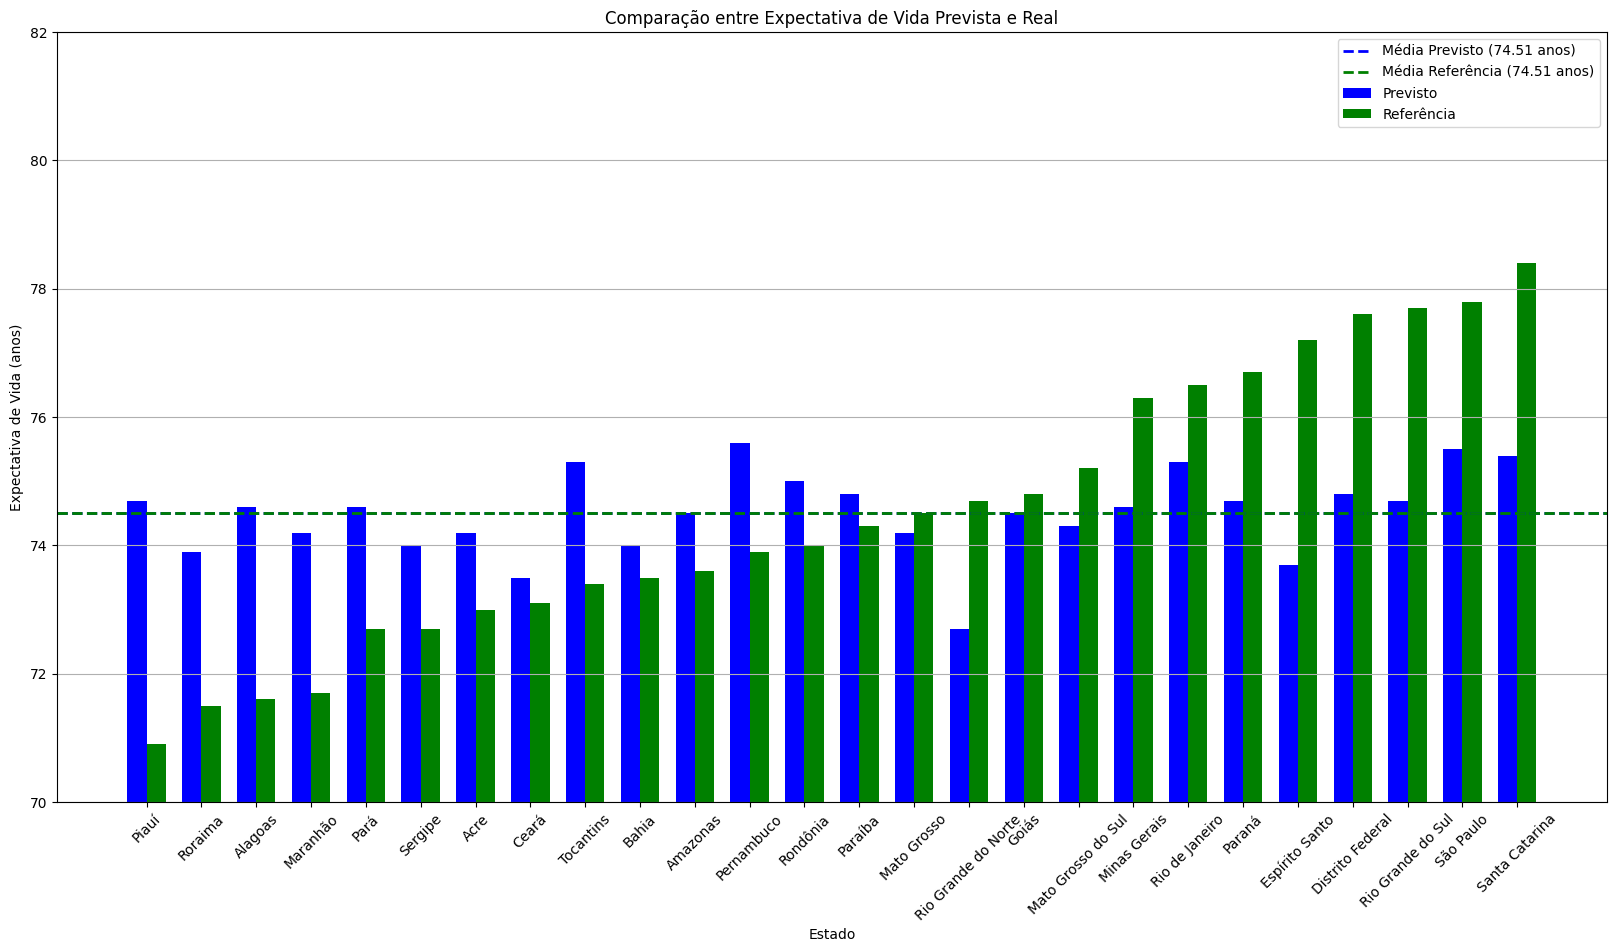

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Ordena o DataFrame com base no valor de referência (Expectativa_de_Vida) de forma crescente
df_sorted = df_analises.sort_values(by="Expectativa_de_Vida")

# Calcula as médias
mean_pred = df_sorted["Predicted_Expectativa_de_Vida"].mean()
mean_ref = df_sorted["Expectativa_de_Vida"].mean()

# Cria as posições no eixo x para cada estado
x = np.arange(len(df_sorted))
width = 0.35  # largura das barras

plt.figure(figsize=(20, 10))

# Cria as barras para os valores preditos e de referência
plt.bar(x - width/2, df_sorted["Predicted_Expectativa_de_Vida"], width, label="Previsto", color="blue")
plt.bar(x + width/2, df_sorted["Expectativa_de_Vida"], width, label="Referência", color="green")

# Adiciona as linhas de média para os valores preditos e de referência
plt.axhline(mean_pred, color='blue', linestyle='--', linewidth=2, label=f"Média Previsto ({mean_pred:.2f} anos)")
plt.axhline(mean_ref, color='green', linestyle='--', linewidth=2, label=f"Média Referência ({mean_ref:.2f} anos)")

# Configura os rótulos e títulos
plt.xlabel("Estado")
plt.ylabel("Expectativa de Vida (anos)")
plt.title("Comparação entre Expectativa de Vida Prevista e Real")
plt.xticks(x, df_sorted["Estado"], rotation=45)
plt.ylim([70, 82])
plt.legend()
plt.grid(axis='y')

plt.show()
